In [16]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import seaborn as sn

import whois

### Reading Data

In [17]:
# Reading data from csv file
data = pd.read_csv("data.csv")
data.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


In [18]:
data.shape

(420464, 2)

In [19]:
data['label'].unique()

array(['bad', 'good'], dtype=object)

### Data Preprocessing

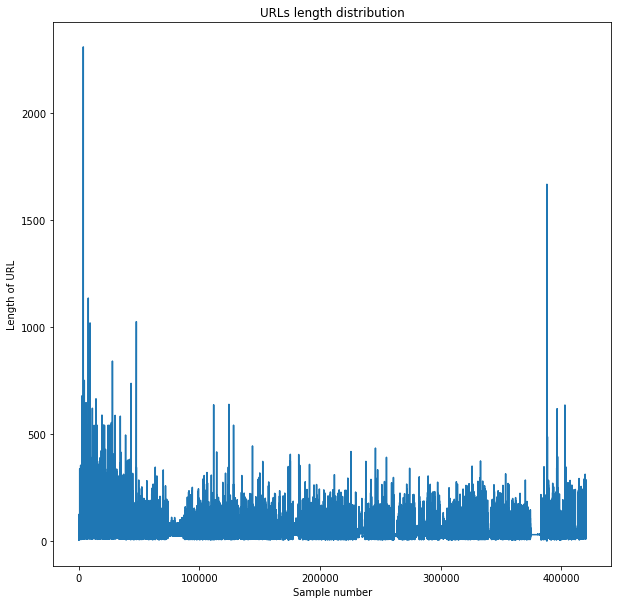

In [20]:
def plot_sample_length_distribution(urls):
    plt.figure(figsize=(10,10))
    plt.plot([x for x in range(len(urls))], [len(s) for s in urls])
#     plt.hist([len(s) for s in urls], 50)
    plt.xlabel('Sample number')
    plt.ylabel('Length of URL')
    plt.title('URLs length distribution')
    plt.show()

plot_sample_length_distribution(data['url'])

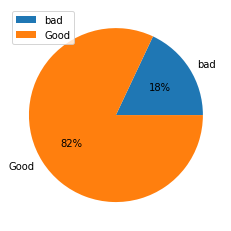

In [21]:
counts = data.groupby(['label']).size()

plt.pie(counts, labels = ['bad', 'Good'], autopct='%.0f%%')
plt.legend()


#### malicious = 1 <br> Normal = 0

In [22]:
data['label'] = np.where(data['label']=='bad',1,0)

In [23]:
data['label'].value_counts()

0    344821
1     75643
Name: label, dtype: int64

## Balancing the data

### 1. Performing under sampling

In [24]:
df0_count, df1_count = data['label'].value_counts()

In [25]:
# divide by class
df0 = data[data['label'] == 0]
df1 = data[data['label'] == 1]

In [26]:
df0.shape

(344821, 2)

In [27]:
df1.shape

(75643, 2)

In [28]:
df0_under = df0.sample(df1_count)

In [29]:
data_balanced_under_sampling = pd.concat([df0_under, df1], axis=0)

In [30]:
data_balanced_under_sampling = data_balanced_under_sampling.sample(frac=1) 
data_balanced_under_sampling

,url,label
391785,DsK3K8a4pTOdUIPk.net/Hy/m7/%2D_BY4/zky9%2CWjEG...,1
173660,adkreal.com/,0
297993,muellerinc.com/locations/locations_25.php,0
11096,smrhs.edu.bd/www.Dropbox.com/Documentview/Drop...,1
335010,signvibe.com/index.php?route=product/product&p...,0
...,...,...
406751,lust-vodka.com/g766d4ft,1
405552,kafemar.com/rlqulla,1
136957,quotes.lucywho.com/jeff-hardy-quotes-t41553.html,0
244887,forbes.com/lists/2009/31/hockey-values-09_Colo...,0


In [44]:
# get target feature
y = data_balanced_under_sampling["label"]

# get dependent features
urls = data_balanced_under_sampling["url"]

In [45]:
# Split into training and testing dataset 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(urls, y, test_size=0.2, random_state=42, stratify=y)

### Using count vectorizer

In [46]:
cv = CountVectorizer(max_features=10000)

# creating vectors for traning data
X_train_cv = cv.fit_transform(X_train)
# creating vectors for testing data
X_test_cv = cv.transform(X_test)

In [47]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 10000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [48]:
cv_results = []
cv_results.append(('Classifier','Accurary','Precision', 'Recall','F1-Score'))

### logistic regression

In [49]:
# Model Building using logistic regression
logit = LogisticRegression()
logit.fit(X_train_cv, y_train)

c:\Users\ritik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy of Logistic Regression model is:  0.9270606120695354

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     15129
           1       0.96      0.89      0.92     15129

    accuracy                           0.93     30258
   macro avg       0.93      0.93      0.93     30258
weighted avg       0.93      0.93      0.93     30258



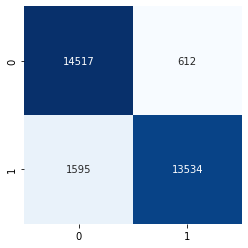

In [50]:
logit_cv_pred = logit.predict(X_test_cv)

cm = confusion_matrix(y_test, logit_cv_pred)
ac = accuracy_score(y_test, logit_cv_pred)
# Accuracy of Our Model
print("Accuracy of Logistic Regression model is: ",ac)
print()
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

print(classification_report(y_test, logit_cv_pred))

In [51]:
cv_results.append(("LogR ", accuracy_score(y_test,  logit_cv_pred)*100,
                precision_score(y_test,  logit_cv_pred)*100,
                recall_score(y_test,  logit_cv_pred)*100,
                f1_score(y_test,  logit_cv_pred)*100 ))

In [52]:
cv_results

[('Classifier', 'Accurary', 'Precision', 'Recall', 'F1-Score'),
 ('LogR ',
  92.70606120695354,
  95.67368867524388,
  89.45733359772622,
  92.46114432109309)]

In [69]:
url = "www.google.com"


In [70]:
url = url[url.find('//')+1: ]


In [73]:
url

'www.google.com'

In [75]:
url[4:]

'google.com'

In [76]:
r = logit.predict(cv.transform(['facebook.com']))

In [79]:
r[0] == 0

True

### Pickle the model

In [25]:
import pickle

In [28]:
# pickle model
with open('model_pkl', 'wb') as files:
    pickle.dump(logit, files)

with open('count_vectorizer', 'wb') as files:
    pickle.dump(cv, files)

### Applying Naive Bayes

Accuracy of Naive Bayes model is:  0.9234252098618547
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     15129
           1       0.96      0.89      0.92     15129

    accuracy                           0.92     30258
   macro avg       0.93      0.92      0.92     30258
weighted avg       0.93      0.92      0.92     30258



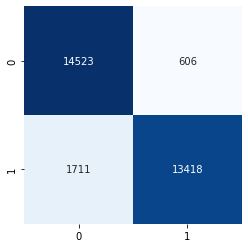

In [29]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_cv, y_train)

mnb_cv_pred = mnb.predict(X_test_cv)

cm = confusion_matrix(y_test, mnb_cv_pred)
ac = accuracy_score(y_test, mnb_cv_pred)
# Accuracy of Our Model
print("Accuracy of Naive Bayes model is: ",ac)

# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

print(classification_report(y_test, mnb_cv_pred))

In [30]:
cv_results.append(("MNB ", accuracy_score(y_test,  mnb_cv_pred)*100,
                precision_score(y_test,  mnb_cv_pred)*100,
                recall_score(y_test,  mnb_cv_pred)*100,
                f1_score(y_test,  mnb_cv_pred)*100 ))

### Applying Decision Tree

Accuracy of Decision Tree model is:  0.9205168880957102
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     15129
           1       0.95      0.89      0.92     15129

    accuracy                           0.92     30258
   macro avg       0.92      0.92      0.92     30258
weighted avg       0.92      0.92      0.92     30258



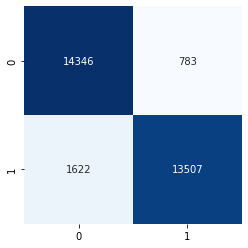

In [31]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train_cv, y_train)

dt_cv_pred = dtc.predict(X_test_cv)

cm = confusion_matrix(y_test, dt_cv_pred)
ac = accuracy_score(y_test, dt_cv_pred)
# Accuracy of Our Model
print("Accuracy of Decision Tree model is: ",ac)

# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

print(classification_report(y_test, dt_cv_pred))

In [32]:
cv_results.append(("DT ", accuracy_score(y_test,  dt_cv_pred)*100,
                precision_score(y_test,  dt_cv_pred)*100,
                recall_score(y_test,  dt_cv_pred)*100,
                f1_score(y_test,  dt_cv_pred)*100 ))

In [34]:
pd.DataFrame(cv_results)

,0,1,2,3,4
0,Classifier,Accurary,Precision,Recall,F1-Score
1,LogR,93.000198,96.089267,89.649018,92.757489
2,MNB,92.342521,95.678836,88.690594,92.052276
3,DT,92.051689,94.520644,89.278868,91.825011


In [44]:
w = cv.transform(['facebook.com']).toarray()

In [45]:
logit.predict(w)

array([0])

### Creating TF-IDF Vectors 

In [47]:
# Using Tokenizer
vectorizer = TfidfVectorizer(max_features=10000)

# creating tf-idf vectors for traning data
X_train_tf_idf = vectorizer.fit_transform(X_train)
# creating tf-idf vectors for testing data
X_test_tf_idf = vectorizer.transform(X_test)

In [48]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 10000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [49]:
tf_idf_results = []
tf_idf_results.append(('Classifier','Accurary','Precision', 'Recall','F1-Score'))

### Applying Logistic Regression

In [50]:
# Model Building using logistic regression
logit = LogisticRegression()
logit.fit(X_train_tf_idf, y_train)

c:\Users\ritik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [51]:
logit_tf_idf_pred = logit.predict(X_test_tf_idf)

In [52]:
cm = confusion_matrix(y_test, logit_tf_idf_pred)
ac = accuracy_score(y_test, logit_tf_idf_pred)
# Accuracy of Our Model
print("Accuracy of Logistic Regression model is: ",ac)

Accuracy of Logistic Regression model is:  0.9316874876065834


<AxesSubplot:>

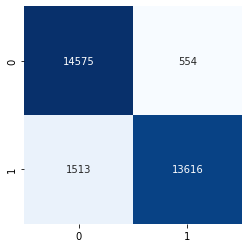

In [53]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [54]:
print(classification_report(y_test, logit_tf_idf_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     15129
           1       0.96      0.90      0.93     15129

    accuracy                           0.93     30258
   macro avg       0.93      0.93      0.93     30258
weighted avg       0.93      0.93      0.93     30258



In [55]:
tf_idf_results.append(("LogR ", accuracy_score(y_test,  logit_tf_idf_pred)*100,
                precision_score(y_test,  logit_tf_idf_pred)*100,
                recall_score(y_test,  logit_tf_idf_pred)*100,
                f1_score(y_test,  logit_tf_idf_pred)*100 ))


### Applying Naive Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tf_idf, y_train)

MultinomialNB()

In [57]:
mnb_tf_idf_pred = mnb.predict(X_test_tf_idf)

In [58]:
cm = confusion_matrix(y_test, mnb_tf_idf_pred)
ac = accuracy_score(y_test, mnb_tf_idf_pred)
# Accuracy of Our Model
print("Accuracy of SVM model is: ",ac)

Accuracy of SVM model is:  0.9289113622843546


<AxesSubplot:>

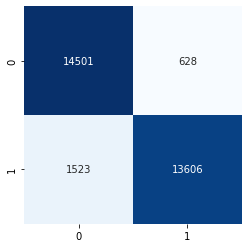

In [59]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [60]:
print(classification_report(y_test, mnb_tf_idf_pred))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     15129
           1       0.96      0.90      0.93     15129

    accuracy                           0.93     30258
   macro avg       0.93      0.93      0.93     30258
weighted avg       0.93      0.93      0.93     30258



In [61]:
tf_idf_results.append(("MNB ", accuracy_score(y_test,  mnb_tf_idf_pred)*100,
                precision_score(y_test,  mnb_tf_idf_pred)*100,
                recall_score(y_test,  mnb_tf_idf_pred)*100,
                f1_score(y_test,  mnb_tf_idf_pred)*100 ))


### Applying Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train_tf_idf, y_train)

DecisionTreeClassifier(criterion='entropy')

In [63]:
dt_tf_idf_pred = dtc.predict(X_test_tf_idf)

In [64]:
cm = confusion_matrix(y_test, dt_tf_idf_pred)
ac = accuracy_score(y_test, dt_tf_idf_pred)
# Accuracy of Our Model
print("Accuracy of SVM model is: ",ac)

Accuracy of SVM model is:  0.9134113292352436


<AxesSubplot:>

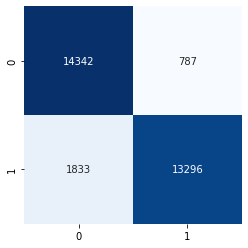

In [65]:
# print confusion matrix
sn.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

In [66]:
print(classification_report(y_test, dt_tf_idf_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     15129
           1       0.94      0.88      0.91     15129

    accuracy                           0.91     30258
   macro avg       0.92      0.91      0.91     30258
weighted avg       0.92      0.91      0.91     30258



In [67]:
tf_idf_results.append(("DT ", accuracy_score(y_test,  dt_tf_idf_pred)*100,
                precision_score(y_test,  dt_tf_idf_pred)*100,
                recall_score(y_test,  dt_tf_idf_pred)*100,
                f1_score(y_test,  dt_tf_idf_pred)*100 ))


In [68]:
pd.DataFrame(tf_idf_results)

,0,1,2,3,4
0,Classifier,Accurary,Precision,Recall,F1-Score
1,LogR,93.168749,96.090332,89.999339,92.945152
2,MNB,92.891136,95.588029,89.933241,92.674454
3,DT,91.341133,94.411702,87.884196,91.031083


### Visualize Results

#### CountVectorizer

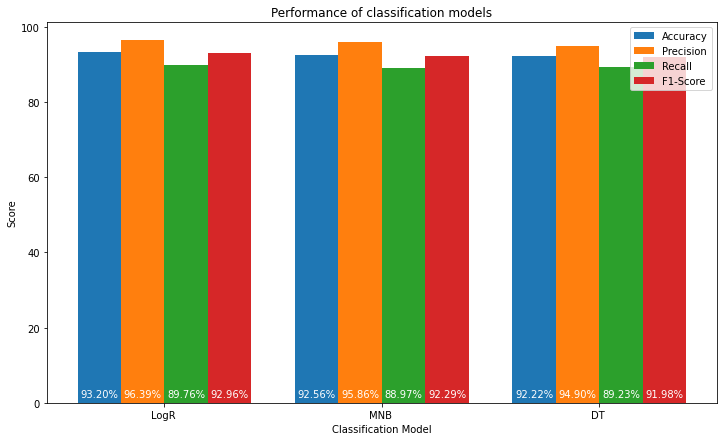

In [69]:
plt.figure(figsize=(12,7))
X_axis = np.arange(len(cv_results)-1)
models_name = [x[0] for x in cv_results[1:]]

accuracy_list = [x[1] for x in cv_results[1:]]
precision_list = [x[2] for x in cv_results[1:]]
recall_list = [x[3] for x in cv_results[1:]]
f1_list = [x[4] for x in cv_results[1:]]


p1 = plt.bar(X_axis - 0.3, accuracy_list, 0.2, label = 'Accuracy')
for rect in p1:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p2 = plt.bar(X_axis - 0.1, precision_list, 0.2, label = 'Precision')
for rect in p2:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p3 = plt.bar(X_axis + 0.1, recall_list, 0.2, label = 'Recall')
for rect in p3:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p4 = plt.bar(X_axis + 0.3, f1_list, 0.2, label = 'F1-Score')
for rect in p4:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')


plt.xticks(X_axis, models_name)
plt.xlabel("Classification Model")
plt.ylabel("Score")
plt.title("Performance of classification models")
plt.legend(loc='upper right')
plt.show()

#### TFIDF Vectorizer

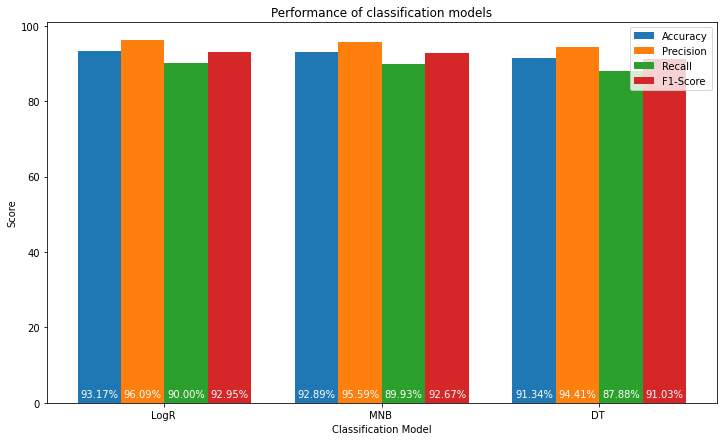

In [70]:
plt.figure(figsize=(12,7))
X_axis = np.arange(len(tf_idf_results)-1)
models_name = [x[0] for x in tf_idf_results[1:]]

accuracy_list = [x[1] for x in tf_idf_results[1:]]
precision_list = [x[2] for x in tf_idf_results[1:]]
recall_list = [x[3] for x in tf_idf_results[1:]]
f1_list = [x[4] for x in tf_idf_results[1:]]


p1 = plt.bar(X_axis - 0.3, accuracy_list, 0.2, label = 'Accuracy')
for rect in p1:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p2 = plt.bar(X_axis - 0.1, precision_list, 0.2, label = 'Precision')
for rect in p2:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p3 = plt.bar(X_axis + 0.1, recall_list, 0.2, label = 'Recall')
for rect in p3:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')
    
p4 = plt.bar(X_axis + 0.3, f1_list, 0.2, label = 'F1-Score')
for rect in p4:
    height = rect.get_height()
    plt.annotate( "{:.2f}%".format(height),(rect.get_x() + rect.get_width()/2, 1),ha="center",va="bottom",fontsize=10, color='white')


plt.xticks(X_axis, models_name)
plt.xlabel("Classification Model")
plt.ylabel("Score")
plt.title("Performance of classification models")
plt.legend(loc='upper right')
plt.show()

### Extacting Domain level features

In [68]:
from tqdm import tqdm
import datetime
from tld import get_tld

In [60]:
w = whois.whois('tryjaar.com')

In [61]:
def extract_domain_features(data):
    today = datetime.datetime.now()
    domain_features = {"website_age" : [],
                    "website_last_updated_dur" : [],
                    "expiry_date" : [],
                    "country" :[],
                    "state" : [],
                    "tld":[ ]}  
    
    for url in tqdm(data):
        # get whois info
        try:
            whois_info = whois.whois(url)
            domain_features["website_age"].append((today - min(whois_info["creation_date"])).days) 
            domain_features["website_last_updated_dur"].append((today - max(whois_info["updated_date"])).days)
            domain_features["expiry_date"].append((min(whois_info["expiration_date"])-today).days)
            domain_features["country"].append(whois_info["country"])
            domain_features["state"].append(whois_info["state"])
            # get top level domain
            try:
                domain_tld = get_tld(url, fix_protocol=True)
            except:
                domain_tld = None
            print(domain_tld)
            domain_features["tld"].append(domain_tld)
            
        except:
            domain_features["website_age"].append(None) 
            domain_features["website_last_updated_dur"].append(None)
            domain_features["expiry_date"].append(None)
            domain_features["country"].append(None)
            domain_features["state"].append(None)
            domain_features["tld"].append(None)
            
    return domain_features

In [62]:
s = extract_domain_features(list(data["url"])[:10])

 10%|████████▎                                                                          | 1/10 [00:01<00:09,  1.08s/it]

com


 30%|████████████████████████▉                                                          | 3/10 [00:02<00:05,  1.22it/s]

com


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:06<00:06,  1.36s/it]

net


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.03s/it]


In [102]:
s

{'website_age': [5718,
  None,
  5718,
  6163,
  None,
  6787,
  None,
  None,
  None,
  None,
  None],
 'website_last_updated_dur': [14,
  None,
  14,
  None,
  16,
  None,
  None,
  None,
  None,
  None],
 'expiry_date': [125, None, 125, None, 152, None, None, None, None, None],
 'country': ['US', None, 'US', None, 'US', None, None, None, None, None],
 'state': ['Arizona',
  None,
  'Arizona',
  None,
  'Arizona',
  None,
  None,
  None,
  None,
  None],
 'tld': ['com', None, 'com', None, 'net', None, None, None, None, None]}

In [84]:
get_tld("http://google.co.uk")

'co.uk'

In [51]:
w

{'domain_name': ['TRYJAAR.COM', 'tryjaar.com'],
 'registrar': 'REALTIME REGISTER B.V.',
 'whois_server': 'whois.yoursrs.com',
 'referral_url': None,
 'updated_date': [datetime.datetime(2022, 8, 9, 19, 55, 40),
  datetime.datetime(2022, 8, 29, 8, 41, 35)],
 'creation_date': datetime.datetime(2022, 8, 9, 19, 54, 22),
 'expiration_date': datetime.datetime(2023, 8, 9, 19, 54, 22),
 'name_servers': ['NS1.DNS-PARKING.COM',
  'NS2.DNS-PARKING.COM',
  'ns1.dns-parking.com',
  'ns2.dns-parking.com'],
 'status': ['clientTransferProhibited https://icann.org/epp#clientTransferProhibited',
  'ok http://www.icann.org/epp#ok',
  'clientTransferProhibited http://www.icann.org/epp#clientTransferProhibited'],
 'emails': ['rtr-security-threats@realtimeregister.com',
  'abuse@hostinger.com'],
 'dnssec': ['unsigned', 'not'],
 'name': 'REDACTED FOR PRIVACY',
 'org': 'REDACTED FOR PRIVACY',
 'address': 'REDACTED FOR PRIVACY',
 'city': 'REDACTED FOR PRIVACY',
 'state': 'Rajasthan',
 'registrant_postal_code': 

In [69]:
max(w["updated_date"])

datetime.datetime(2022, 8, 29, 8, 41, 35)

In [65]:
(today - w["creation_date"]).days

39

In [43]:
list(data['url'])[:10]

['diaryofagameaddict.com',
 'espdesign.com.au',
 'iamagameaddict.com',
 'kalantzis.net',
 'slightlyoffcenter.net',
 'toddscarwash.com',
 'tubemoviez.com',
 'ipl.hk',
 'crackspider.us/toolbar/install.php?pack=exe',
 'pos-kupang.com/']

In [99]:
  get_tld('espdesign.com.au', fix_protocol=True)

'com.au'